# Test Harness - TekMap Object
### Thomas Ales |  June 2020

Description:   
Proof of concept code, and test code for the TekMap object. Used to represent an Y-axis collection of TekData objects. TekData objects represent rows in the scan, and the TekMap object represents the XY collection. 


In [1]:
import time
import MapData

Set `data_directory` to a collection of RF- / DC- .WFM files

In [2]:
data_directory = "/home/tka/source/data/customer042/PostFix/TestScan_120"

Setup the `MapData` object by giving it a `data_directory`.

Metadata:
----------  
acq_angle - SAW Angle in Degrees  
x_start - X-Origin from scanengine2 in mm  
y_start - Y-Origin from scanengine2 in mm  
x_delta - Representation of expected dx/ds, here stagespeed/heliosfrequency  

`assemble_dcmap` organizes the loaded files into the correct order.

In [3]:
_s1 = time.time()
test_MapData = MapData.TekMap(data_directory)
test_MapData.metadata["acq_angle"] = 0
test_MapData.metadata["x_start"] = 43.00
test_MapData.metadata["y_start"] = 40.00
test_MapData.metadata["x_delta"] = 0.005
test_MapData.metadata["y_delta"] = 0.100
test_MapData.metadata["sample_desc"] = "Test Sample"
_e = time.time()
print("Execution time: {0:.5f}s".format(_e - _s1))

Found 180 & 180 DC / RF Files
Execution time: 0.09685s


## DC Offset Test
### Assembly and Plot

```
import glob
from multiprocessing import Pool
import pandas as pd
import tekwfm
import matplotlib.pyplot as plt
dc_filelist = []
os.chdir(data_directory)
for current in glob.glob("*.wfm"):
    if current.startswith("DC-"):
        dc_filelist.append(data_directory + "/" + current)
dc_filelist.sort()
s12 = time.time()
mp = Pool(processes=4)
output_dc = list(mp.map(test_MapData.waveforms[0].mp_compute_dcvoltage, dc_filelist))
dfoutput = pd.DataFrame(output_dc)
s13 = time.time()
print("4-t execution time: {0:.4f}".format(s13-s12))
plt.imshow(dfoutput, aspect=3601/180)
```

In [4]:
s1 = time.time()
test_MapData.mp_assemble_dcmap()
_result = test_MapData.dc_map
s2 = time.time()
print("Execution time: {0:.4f}".format(s2-s1))

Execution time: 10.0821


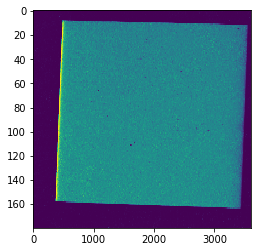

In [5]:
import matplotlib.pyplot as plt
plt.imshow(_result, aspect=3601/180)

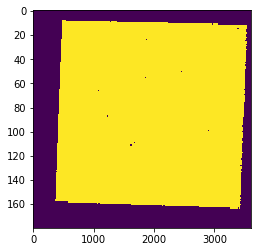

In [6]:
test_MapData.compute_dcmask()
plt.imshow(test_MapData.dc_mask, aspect=3601/180)

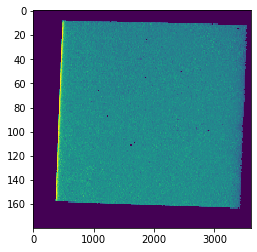

In [7]:
masked_dc = test_MapData.dc_map * test_MapData.dc_mask
plt.imshow(masked_dc, aspect=3601/180)

In [8]:
s3 = time.time()
test_MapData.mp_assemble_fftmap()
s4 = time.time()
print("Execution Time: {0:.4f}".format(s4-s3))

Execution Time: 457.4923


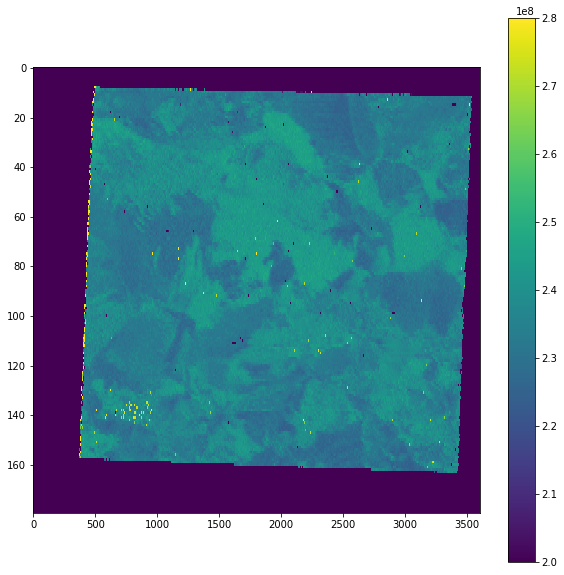

In [16]:
plt.figure(figsize=[10,10])
plt.imshow(test_MapData.rf_map, aspect=3601/180)
plt.clim([200e6, 280e6])
plt.colorbar()

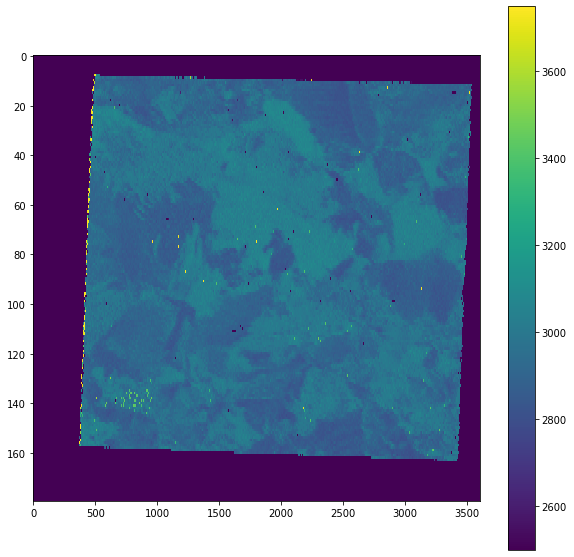

In [10]:

plt.figure(figsize=[10, 10])
plt.imshow(test_MapData.velocity_map, aspect=3601/180)
plt.colorbar()
plt.clim([2500, 3750])

Proof of concept / prototyping code for `TekMap.assemble_dcmap`

```
import numpy as np
dc_map = []
for idx in range(0, test_MapData.waveforms.__len__()):
    dc_map.append([idx, test_MapData.waveforms[idx][1].mean_dc_level])

dc_map.sort
import matplotlib.pyplot as plt

img_map = []
for line in dc_map:
    img_map.append(line[1])
plt.figure(figsize=[10, 10])
plt.imshow(img_map, aspect=3601/180)
plt.clim(0.080, 0.300)
plt.colorbar()
```

In [11]:
_s = time.time()
test_MapData.assemble_velocitymap() # Default spacing is 25 microns
test_MapData.plot_velocitymap()
_e = time.time()
print("Execution time: {0:.5f}s".format(_e - _s))

AttributeError: 'list' object has no attribute 'frames_in_file'

Prototype code for `TekMap.assemble_rf_voltagemap()`

```
import tekwfm
_vt, _ts, _tsc, _tf, _tdf, _td = tekwfm.read_wfm(test_MapData.waveforms[100][1].rf_filename)
_vtdf = pd.DataFrame(_vt)
_record = []
for record_index in range(0, test_MapData.waveforms[100][1].frames_in_file):
    _maxvoltidx = _vtdf[record_index].argmax()
    _record.append(_vtdf.loc[_maxvoltidx, record_index])
_recdf = pd.DataFrame(_record)
plt.plot(_recdf)
```

Execution time: 0.04410s
Total test execution time: 470.54593s


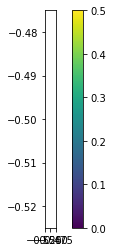

In [12]:
import matplotlib.pyplot as plt
_s = time.time()
test_MapData.assemble_rf_voltagemap()
plt.imshow(test_MapData.rf_voltagemap, aspect=3601/180)
plt.colorbar()
plt.clim(0.0, 0.5)
_e1 = time.time()
print("Execution time: {0:.5f}s".format(_e1 - _s))
print("Total test execution time: {0:.5f}s".format(_e1 - _s1))

```
import tekwfm
import pandas as pd
import scipy as sp
import numpy as np
def compute_fft(file_name):
    diag = False
    _vt, _ts, _tsc, _tf, _tdf, _td = tekwfm.read_wfm(file_name)
    sample_rate = int(1 / _tsc)

    if(diag):
        print("Loaded {0}".format(file_name))
        print("Detected Sample Rate: {0}".format(sample_rate))

    _vtdf = pd.DataFrame(_vt)
    _recordlen, _numrecords = _vtdf.shape
    
    if(diag):
        print("Records: {0}\tLength: {1} points".format(_numrecords, _recordlen))

    results = []
    for record_idx in range(0, _numrecords):
        _vtr = _vtdf[record_idx]
        _vtidxmax = _vtr.argmax()
        if(_vtidxmax < 512):
            _vtidxmax = 512
            _vts = _vtr.loc[0:1024]
        else:
            _min = _vtidxmax - 511
            _max = _vtidxmax + 512
            _vts = _vtr.loc[_min:_max]

        _fftpower = pd.Series(sp.fft.rfft(list(_vts)))
        _fftfreq = pd.Series(list(sp.fft.fftfreq(_fftpower.__len__())  * sample_rate))
        _fftmax = _fftpower.argmax()
        _fftmaxval = _fftfreq[_fftmax]
        results.append(_fftmaxval)

    return results

```